In [1]:
import csv
import math
import pandas as pd
import cv2
import mediapipe as mp

In [2]:
def calculate_angle(point1, center_point, point2):
    """Calculate the angle between three points."""
    # Calculate vectors
    vec1 = (point1[0] - center_point[0], point1[1] - center_point[1])
    vec2 = (point2[0] - center_point[0], point2[1] - center_point[1])
    
    # Calculate dot product and magnitude of vectors
    dot_product = vec1[0] * vec2[0] + vec1[1] * vec2[1]
    magnitude1 = math.sqrt(vec1[0] ** 2 + vec1[1] ** 2)
    magnitude2 = math.sqrt(vec2[0] ** 2 + vec2[1] ** 2)
    
    # Calculate angle in radians
    angle_rad = math.acos(dot_product / (magnitude1 * magnitude2))
    
    # Convert angle to degrees
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

In [3]:
def angles(df):
    # Extracting important landmarks
    land1 = df[['Landmark_11','Landmark_13','Landmark_15','Landmark_12','Landmark_14','Landmark_16','Landmark_23','Landmark_25','Landmark_27','Landmark_24','Landmark_26','Landmark_28']]
    
    # Renaming the columns
    land1 = land1.rename(columns={
        'Landmark_11': 'left_shoulder',
        'Landmark_13': 'left_elbow',
        'Landmark_15': 'left_wrist',
        'Landmark_12': 'right_shoulder',
        'Landmark_14': 'right_elbow',
        'Landmark_16': 'right_wrist',
        'Landmark_23': 'left_hip',
        'Landmark_25': 'left_knee',
        'Landmark_27': 'left_ankle',
        'Landmark_24': 'right_hip',
        'Landmark_26': 'right_knee',
        'Landmark_28': 'right_ankle'
    })
    land1 = land1.dropna()
    land1 = land1.map(lambda x: tuple(map(float, x.split(','))))
    
    # Calculating angles of body parts
    land1['left_arm_angle'] = land1.apply(lambda row: calculate_angle(row['left_shoulder'], row['left_elbow'], row['left_wrist']), axis=1)
    land1['right_arm_angle'] = land1.apply(lambda row: calculate_angle(row['right_shoulder'], row['right_elbow'], row['right_wrist']), axis=1)
    land1['left_leg_angle'] = land1.apply(lambda row: calculate_angle(row['left_hip'], row['left_knee'], row['left_ankle']), axis=1)
    land1['right_leg_angle'] = land1.apply(lambda row: calculate_angle(row['right_hip'], row['right_knee'], row['right_ankle']), axis=1)
    
    angles = land1[['left_arm_angle','right_arm_angle','left_leg_angle','right_leg_angle']].copy()
    return angles

In [4]:
def compare_angles(df1, df2, arm_thres =90, leg_thres=90):
    num_rows = min(len(df1), len(df2))
    num_same_poses = 0
    bad_poses = []
    
    
    for i in range(num_rows):
        row1 = df1.iloc[i]
        row2 = df2.iloc[i]
        
        # Calculate absolute differences between corresponding angles
        angle_diffs = abs(row1 - row2)
        # print(angle_diffs)

        # Check if all absolute differences are below the threshold
        if (angle_diffs.iloc[0] < arm_thres) and (angle_diffs.iloc[1] < arm_thres) and (angle_diffs.iloc[2] < arm_thres) and (angle_diffs.iloc[3] < leg_thres):
            num_same_poses += 1
        else:
            bad_poses.append(i)
    
    # Calculate accuracy percentage
    accuracy_percentage = (num_same_poses / num_rows) * 100 if num_rows > 0 else 0
    print(f"Your accuracy percentage is {accuracy_percentage:.2f}%")
    
    return accuracy_percentage, bad_poses

In [5]:
def calculate_slope(point1, point2):
    """Calculate the slope of the line defined by two points."""
    if point1[0] == point2[0]:
        return float('inf')  # Vertical line
    return (point2[1] - point1[1]) / (point2[0] - point1[0])

In [6]:
def slopes(df):
    # Extracting important landmarks
    land1 = df[['Landmark_11', 'Landmark_13', 'Landmark_15', 'Landmark_12', 'Landmark_14', 'Landmark_16', 'Landmark_23', 'Landmark_25', 'Landmark_27', 'Landmark_24', 'Landmark_26', 'Landmark_28']]
    
    # Renaming the columns
    land1 = land1.rename(columns={
        'Landmark_11': 'left_shoulder',
        'Landmark_13': 'left_elbow',
        'Landmark_15': 'left_wrist',
        'Landmark_12': 'right_shoulder',
        'Landmark_14': 'right_elbow',
        'Landmark_16': 'right_wrist',
        'Landmark_23': 'left_hip',
        'Landmark_25': 'left_knee',
        'Landmark_27': 'left_ankle',
        'Landmark_24': 'right_hip',
        'Landmark_26': 'right_knee',
        'Landmark_28': 'right_ankle'
    })
    
    land1 = land1.dropna()
    land1 = land1.applymap(lambda x: tuple(map(float, x.split(','))))
    
    # Calculating slopes of body parts
    # land1['left_upper_arm_slope'] = land1.apply(lambda row: calculate_slope(row['left_shoulder'], row['left_elbow']), axis=1)
    land1['left_lower_arm_slope'] = land1.apply(lambda row: calculate_slope(row['left_elbow'], row['left_wrist']), axis=1)
    # land1['right_upper_arm_slope'] = land1.apply(lambda row: calculate_slope(row['right_shoulder'], row['right_elbow']), axis=1)
    land1['right_lower_arm_slope'] = land1.apply(lambda row: calculate_slope(row['right_elbow'], row['right_wrist']), axis=1)
    # land1['left_upper_leg_slope'] = land1.apply(lambda row: calculate_slope(row['left_hip'], row['left_knee']), axis=1)
    land1['left_lower_leg_slope'] = land1.apply(lambda row: calculate_slope(row['left_knee'], row['left_ankle']), axis=1)
    # land1['right_upper_leg_slope'] = land1.apply(lambda row: calculate_slope(row['right_hip'], row['right_knee']), axis=1)
    land1['right_lower_leg_slope'] = land1.apply(lambda row: calculate_slope(row['right_knee'], row['right_ankle']), axis=1)
    
    # slopes = land1[['left_upper_arm_slope', 'left_lower_arm_slope', 'right_upper_arm_slope', 'right_lower_arm_slope', 'left_upper_leg_slope', 'left_lower_leg_slope', 'right_upper_leg_slope', 'right_lower_leg_slope']].copy()
    slopes = land1[['left_lower_arm_slope', 'right_lower_arm_slope', 'left_lower_leg_slope', 'right_lower_leg_slope']].copy()
    return slopes

In [7]:
def compare_slopes(df1, df2, arm_thres =10, leg_thres=3):
    num_rows = min(len(df1), len(df2))
    num_same_poses = 0
    
    for i in range(num_rows):
        row1 = df1.iloc[i]
        row2 = df2.iloc[i]
        
        # Calculate ratio of corresponding slopes
        slope_rat = abs(row1 / row2)

        # Check if all ratios are within
        if (((slope_rat.iloc[0] > 1 / arm_thres) and (slope_rat.iloc[0] < arm_thres)) and 
            ((slope_rat.iloc[1] > 1 / arm_thres) and (slope_rat.iloc[1] < arm_thres)) and 
            ((slope_rat.iloc[2] > 1 / arm_thres) and (slope_rat.iloc[2] < arm_thres)) and 
            ((slope_rat.iloc[3] > 1 / arm_thres) and (slope_rat.iloc[3] < arm_thres))):
            
            num_same_poses += 1
            
            
    
    # Calculate accuracy percentage
    accuracy_percentage = (num_same_poses / num_rows) * 100 if num_rows > 0 else 0
    
    return accuracy_percentage

In [8]:
# Importing data
df1 = pd.read_csv('landmarks_video_ref.csv')
df2 = pd.read_csv('landmarks_video_bad.csv')
df3 = pd.read_csv('landmarks_video_ok.csv')
df4 = pd.read_csv('landmarks_video_ok2.csv')
df5 = pd.read_csv('landmarks_video_ok3.csv')
df6 = pd.read_csv('landmarks_video_good.csv')

In [9]:
# Calculating Angles 
angles1 = angles(df1)
angles2 = angles(df2)
angles3 = angles(df3)
angles4 = angles(df4)
angles5 = angles(df5)
angles6 = angles(df6)



In [10]:
# Calculating Accuracy
p1,b1 = compare_angles(angles1, angles2)
p2,b2 = compare_angles(angles1, angles3)
p3,b3 = compare_angles(angles1, angles4)
p4,b4 = compare_angles(angles1, angles5)
p5,b5 = compare_angles(angles1, angles6)


Your accuracy percentage is 55.75%
Your accuracy percentage is 77.43%
Your accuracy percentage is 79.82%
Your accuracy percentage is 83.85%
Your accuracy percentage is 86.06%


In [11]:
# Comparing Slopes
slopes1 = slopes(df1)
slopes2 = slopes(df2)
slopes3 = slopes(df3)
slopes4 = slopes(df4)
slopes5 = slopes(df5)
slopes6 = slopes(df6)

C:\Users\duong\AppData\Local\Temp\ipykernel_13240\1967193792.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  land1 = land1.applymap(lambda x: tuple(map(float, x.split(','))))
C:\Users\duong\AppData\Local\Temp\ipykernel_13240\1967193792.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  land1 = land1.applymap(lambda x: tuple(map(float, x.split(','))))
C:\Users\duong\AppData\Local\Temp\ipykernel_13240\1967193792.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  land1 = land1.applymap(lambda x: tuple(map(float, x.split(','))))
C:\Users\duong\AppData\Local\Temp\ipykernel_13240\1967193792.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  land1 = land1.applymap(lambda x: tuple(map(float, x.split(','))))
C:\Users\duong\AppData\Local\Temp\ipykernel_13240\1967193792.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use D

In [12]:
a = compare_slopes(slopes1, slopes2)
b = compare_slopes(slopes1, slopes3)
c = compare_slopes(slopes1, slopes4)
d = compare_slopes(slopes1, slopes5)
e = compare_slopes(slopes1, slopes6)
print (a,b,c,d,e)

51.32743362831859 57.743362831858406 53.65853658536586 58.62831858407079 63.495575221238944


In [13]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

In [14]:
def show_errors(video_path, window_name1, ref_path, window_name2, bad_frames):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    cap2 = cv2.VideoCapture(ref_path)

    # Create a window for the video
    cv2.namedWindow(window_name1, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name1, 610, 1080)
    cv2.namedWindow(window_name2, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name2, 610, 1080)

    count = 0
    mp_drawing = mp.solutions.drawing_utils
    good = mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2)  
    bad = mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2)  
    
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        ret2, frame2 = cap2.read()
        
        # Check if frame reading was successful
        if not ret:
            break

        if not ret2:
            break
        
        # Convert the image to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Perform pose estimation
        results = pose.process(frame_rgb)
        
        # Draw the pose landmarks on the frame
        if results.pose_landmarks:
            mp_drawing = mp.solutions.drawing_utils
            if count in bad_frames:
                mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=bad, connection_drawing_spec=bad)
            else:
                mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, landmark_drawing_spec=good, connection_drawing_spec=good)
        
        # Display the frame in the window
        cv2.imshow(window_name1, frame)
        cv2.imshow(window_name2, frame2)

        if count == 0:
            cv2.waitKey(0)
        if count in bad_frames:
            bad_key = cv2.waitKey(0)
            if bad_key == ord('q'):
                break
        
        # Check for key press
        key = cv2.waitKey(1)
        
        # Break the loop if 'q' is pressed
        if key == ord('q'):
            break

        count += 1
    
    # Release the video capture object
    cap.release()
    cap2.release()
    cv2.destroyAllWindows()

In [15]:
def filter_consecutive_numbers(lst):
    result = [lst[0]]  # Initialize the result with the first element of the list
    for i in range(1, len(lst)):
        # Check if the current number is not immediately following the previous number
        if lst[i] != lst[i - 1] + 1:
            # If it's not, add it to the result
            result.append(lst[i])
    return result

In [70]:
user_vid = 'good.mp4'
ref_vid = "ref.mp4"
show_errors(user_vid, "User", ref_vid, "Ref", filter_consecutive_numbers(b5))

In [17]:
angles1

,left_arm_angle,right_arm_angle,left_leg_angle,right_leg_angle
0,140.122469,158.515171,166.344386,176.050853
1,142.991576,167.327264,167.528948,176.496998
2,144.588396,172.749460,169.547513,176.447078
3,145.017313,174.220603,169.882631,177.477545
4,145.060180,177.101552,170.547616,179.406570
...,...,...,...,...
447,52.691518,42.224347,141.819601,134.482492
448,49.907516,44.944236,140.563828,126.167866
449,47.052432,50.040647,137.212601,116.785719
450,46.668694,44.692548,133.874022,113.043835


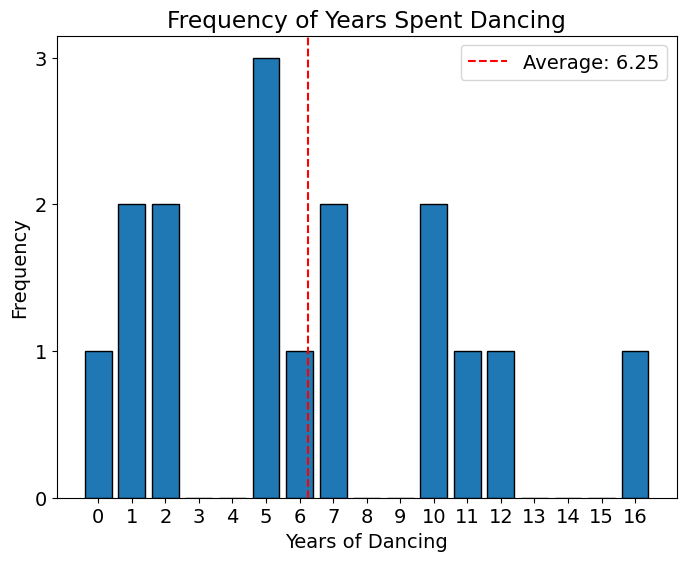

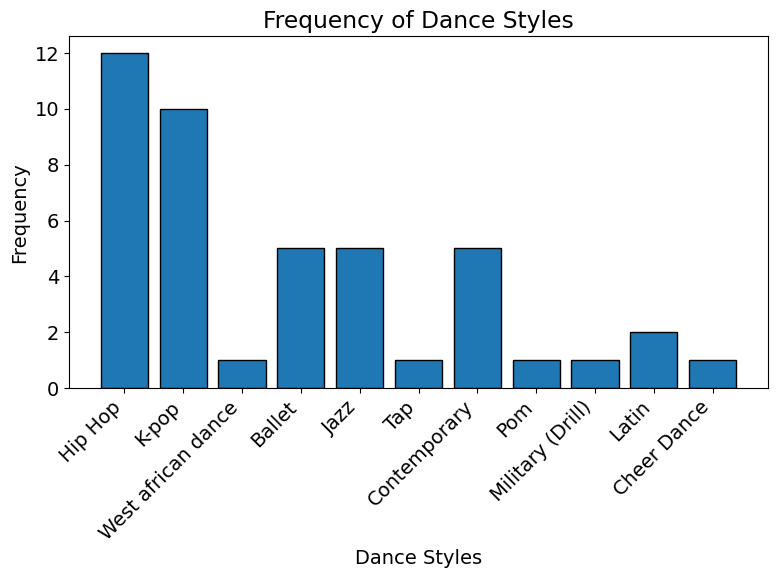

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Increase font size globally
plt.rcParams.update({'font.size': 14})

# Data
years_dancing = [5, 5, 10, 7, 16, 0, 5, 2, 1, 11, 12, 7, 1, 2, 6, 10]

# Calculate histogram using numpy
hist, bins = np.histogram(years_dancing, bins=np.arange(min(years_dancing), max(years_dancing) + 2), density=False)

# Plot histogram
plt.figure(figsize=(8, 6))  # Adjust figsize for consistency
plt.bar(bins[:-1], hist, width=0.8, edgecolor='black', align='center')  # Adjust width for separation
plt.xlabel('Years of Dancing')
plt.ylabel('Frequency')
plt.title('Frequency of Years Spent Dancing')
plt.xticks(np.arange(min(years_dancing), max(years_dancing) + 1, 1))  # Set x-axis ticks to integers
plt.yticks(np.arange(0, max(hist) + 1, 1))  # Set y-axis ticks to integers

# Add a vertical line at the average
average_years = np.mean(years_dancing)
plt.axvline(average_years, color='red', linestyle='--', label=f'Average: {average_years:.2f}')

plt.legend()  # Show legend

plt.savefig('dance_exp.png')

dance_styles = [
    "Hip Hop, K-pop, West african dance",
    "Hip Hop, K-pop",
    "Ballet, Jazz, K-pop, Tap",
    "Ballet, Hip Hop, Contemporary, Pom, Military (Drill)",
    "Hip Hop, Jazz, Contemporary, K-pop",
    "K-pop",
    "K-pop",
    "Hip Hop, Latin, Jazz, Contemporary",
    "Hip Hop, Latin",
    "Ballet, Hip Hop, Jazz, Contemporary",
    "Hip Hop, K-pop, Cheer Dance",
    "Hip Hop",
    "K-pop",
    "Hip Hop, K-pop",
    "Ballet, Hip Hop, K-pop",
    "Ballet, Hip Hop, Jazz, Contemporary"
]

# Split and count occurrences of each dance style
all_styles = [style.strip() for entry in dance_styles for style in entry.split(',')]
style_counts = Counter(all_styles)

# Prepare data for plotting
styles = list(style_counts.keys())
frequencies = list(style_counts.values())

# Plot the frequency plot
plt.figure(figsize=(8, 6))  # Adjust figsize for consistency
plt.bar(styles, frequencies, edgecolor='black')
plt.xlabel('Dance Styles')
plt.ylabel('Frequency')
plt.title('Frequency of Dance Styles')
plt.xticks(rotation=45, ha='right')

plt.savefig('dance_style.png', bbox_inches='tight')

# Show plot
plt.tight_layout()
plt.show()
